# 8. 도로 영역을 찾자! - 세그멘테이션 모델 만들기
## 8-1. 들어가며

<img src="semanticsegmentation.png">  

이번에는 시맨틱 세그멘테이션을 통해 자율주행차량이 주행할 도로영역을 찾는 모델을 만들어봅니다.  
앞선 강의에서 시맨틱 세그멘테이션을 위한 다양한 모델을 배웠는데, 이번에는 U-Net을 사용해서 이미지가 입력되면 도로의 영역을 segmentation하는 모델을 만들어보겠습니다.

모델은 아래에 보이는 것처럼 도로영역을 흰색으로 오버레이합니다.
<img src="result.gif">  

### 실습목표
-------------------------------------------------
  1. 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
  2. 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
  3. 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

### 학습내용
-----------------------------------------------
  1. 시맨틱 세그멘테이션 데이터셋
  2. 시맨틱 세그멘테이션 모델
  3. 시맨틱 세그멘테이션 모델 시각화

## 8-2. 시맨틱 세그멘테이션 데이터셋

### 이미지, 데이터 가져오기
----------------------------------------------------------
먼저 시맨틱 세그멘테이션으로 도로 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋으로 학습할 수 있도록 파싱해야 하낟. 
아래 링크로 object detection때 사용한 KITTI 데이터셋의 세그멘테이션 데이터를 다운로드하자.  
[데이터출처](http://www.cvlibs.net/datasets/kitti/eval_semantics.php)  
```
$ mkdir -p ~/aiffel/semantic_segmentation/data
$ wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
$ unzip data_semantics.zip -d ~/aiffel/semantic_segmentation/data
```  
예시이미지  
<img src="org.png">  
<img src="bw.png">  
<img src="rgb.png">  

Q1. 시맨틱 세그멘테이션의 이미지 라벨의 각 pixel 값은 의미를 갖습니다. 그렇다면 오늘 우리가 시맨틱 세그멘테이션으로 찾아내야 할 도로의 label은  어떤 값일까요? 
공식 홈페이지를 참고하거나 직접 데이터셋을 확인해보셔도 좋습니다. 
(힌트) development kit zip파일 안에 안내되고 있는 라벨 정보를 참고하세요.  
ANS) 7  

### 데이터 로더(data loader) 만들기  
------------------------------------------------------------------
이미지와 데이터셋이 준비되었으니 모델을 학습시킬 데이터로더를 만들어보자.  
입력값, 출력값 모두 (224, 224) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱하자  
데이터로더에 augmentation을 적용해봅시다.  
오늘은 파이썬에서 많이 사용하는 albumentations를 사용해보자. 하지만 imgaug같은 다른 라이브러리를 사용해도 된다.  
```
$ pip install albumentations
```  
학습셋의 일정량을 검증데이터셋으로 활용하도록 설정하자.  
구현할때는 아래 링크를 참고.  
[keras dataloader](https://hwiyong.tistory.com/241)  
[albumentation](https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)  
만든 후에 데이터셋이 잘 파싱되어 나오는직 꼭 확인해야 한다. 데이터셋에 오류가 없어야 성능이 안 나와도 문제를 찾기 쉽다.

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

print('슝=3')

슝=3


albumentation의 사용법을 알아보자.  
아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 예로 imgaug의 Sometimes()와 유사하다.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

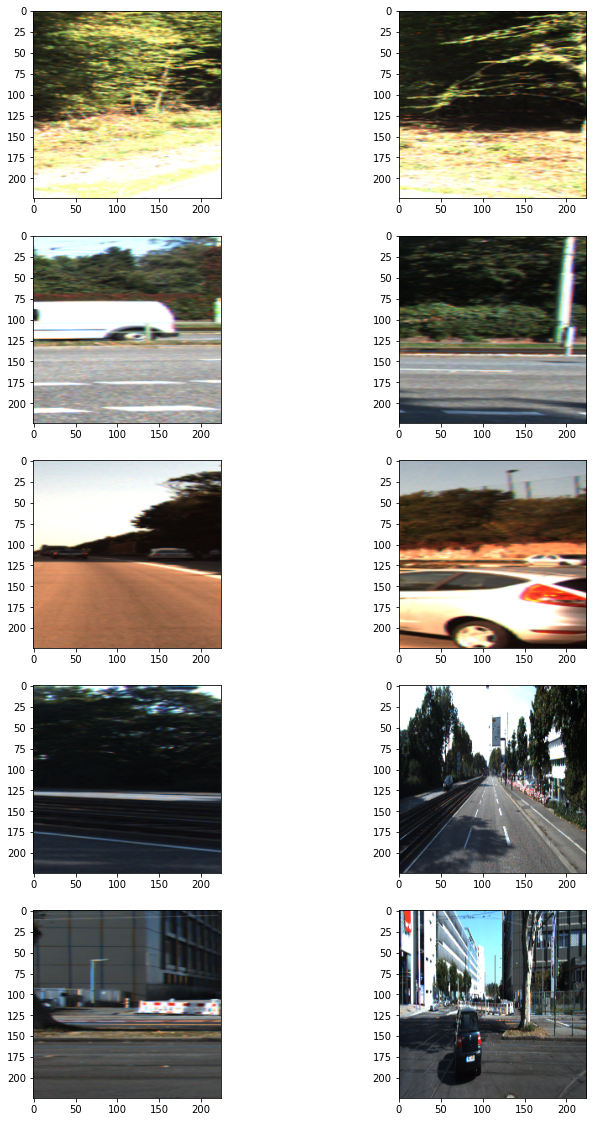

In [3]:
import os

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

데이터셋을 tf.keras.utils.Sequence를 상속받은 generator형태로 데이터 구성

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 8-3. 시매틱 세그멘테이션 모델  
<img src="U_Net.png">  

### 모델 구조 만들기  
------------------------------------------------------------ 
시맨틱 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현해봅시다.  
입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰야 하며 사용에 필요한 레이어와 연산은 아래와 같으며 필요에 따라 Dropout등의 다른 레이어를 적용해보자.
  * Conv2D
  * Conv2DTranspose
  * MaxPooling2D
  * concatenate

In [6]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기  
--------------------------------------
모델을 만들었으니 위에서 만들어본 데이터셋과 학습해봅시다.  
적절한 learning rate와 epoch를 찾아서 모델을 학습하고 저장하자.

In [7]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
11/11 [==============================] - 5s 414ms/step - loss: 0.6939 - val_loss: 0.6926
Epoch 2/100
11/11 [==============================] - 5s 416ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/100
11/11 [==============================] - 5s 418ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/100
11/11 [==============================] - 5s 418ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/100
11/11 [==============================] - 5s 420ms/step - loss: 0.6907 - val_loss: 0.6905
Epoch 6/100
11/11 [==============================] - 5s 420ms/step - loss: 0.6902 - val_loss: 0.6900
Epoch 7/100
11/11 [==============================] - 5s 419ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/100
11/11 [==============================] - 5s 421ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/100
11/11 [==============================] - 5s 419ms/step - loss: 0.6887 - val_loss: 0.6884
Epoch 10/100
11

11/11 [==============================] - 5s 424ms/step - loss: 0.6542 - val_loss: 0.6541
Epoch 77/100
11/11 [==============================] - 5s 427ms/step - loss: 0.6535 - val_loss: 0.6536
Epoch 78/100
11/11 [==============================] - 5s 426ms/step - loss: 0.6530 - val_loss: 0.6531
Epoch 79/100
11/11 [==============================] - 5s 426ms/step - loss: 0.6525 - val_loss: 0.6526
Epoch 80/100
11/11 [==============================] - 5s 426ms/step - loss: 0.6520 - val_loss: 0.6521
Epoch 81/100
11/11 [==============================] - 5s 424ms/step - loss: 0.6514 - val_loss: 0.6516
Epoch 82/100
11/11 [==============================] - 5s 427ms/step - loss: 0.6508 - val_loss: 0.6511
Epoch 83/100
11/11 [==============================] - 5s 425ms/step - loss: 0.6502 - val_loss: 0.6506
Epoch 84/100
11/11 [==============================] - 5s 427ms/step - loss: 0.6502 - val_loss: 0.6501
Epoch 85/100
11/11 [==============================] - 5s 426ms/step - loss: 0.6492 - val_loss: 

## 8-4. 시맨틱 세그멘테이션 모델 시각화  
학습한 모델 결과를 시각화해보자.  
테스트셋은 이미지를 제공하지만, 정답데이터를 제공하지 않기에 눈으로 확인할 수 있도록 모델이 추론한 결과를 세그멘테이션 이미지로 만들자.  
라벨과 이미지를 한번에 보게 모델출력값을 이미지위에 오버레이시키자. PIL패키지의 Image.blend를 활용하면 된다.  
이전스텝의 저장된 모델은 아래 코드로 불러오는 것이 가능하다.  
```
model = tf.keras.models.load_model(model_path)
```

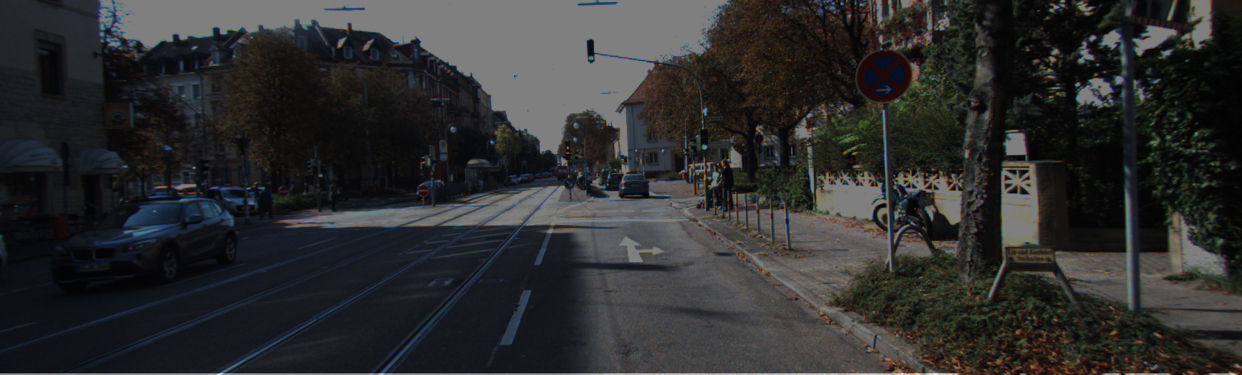

In [8]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
  
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션 성능을 정량적으로 평가하는 방법은 IoU(Intersection over Union)을 계산하는 방법이 있습니다.  
지난 시간에 IoU를 계산하는 법을 소개했기에 그 내용을 활용하여 구현해보자.  
IoU를 계산하기 위해서 모델이 도로라고 판단한 부분을 1, 나머지 부분을 0으로 표시한 행렬과 라벨 데이터에서 도로 영역을 1로, 나머지 부분은 0으로 표시한 행렬이 필요합니다.  
각각을 prediction, target이라고 불렀을때 이를 계산하는 함수를 구현해보자.  
위의 get_output을 좀더 확장해서 output, prediction, target을 함께 리턴하도록 구현해보자. 

In [9]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [10]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [11]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.012870


0.01286981087655968

## 8-5. 프로젝트: 개선된 U-Net 모델 만들기  
U-Net을 통한 시맨틱 세그멘테이션 결과가 충분히 만족스러우신가요? 어느정도 동작하는 것 같긴 하지만 좀더 개선할 여지도 보일 것입니다.  
2018년에 U-Net++라는 논문이 나왔습니다. 이 논문은 기존에 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델입니다.  
그래서 모델의 구조 자체는 아래 그림에서 보는 것처럼 별다른 설명이 없이도 직관적으로 이해가 가능한 수준입니다. 오늘 소개되었던 U-Net의 모델 코드를 조금만 수정 확장하면 충분히 구현할 수 있을 것입니다. 그래서 오늘의 과제는 바로 U-Net++ 모델을 스스로의 힘으로 직접 구현해 보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것입니다. 정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교해 볼 수 있을 것이고, 정량적으로는 동일 이미지에 대한 IoU값을 비교해 보면 될 것입니다.  
[U-Net++저자블로그](https://sh-tsang.medium.com/review-unet-a-nested-u-net-architecture-biomedical-image-segmentation-57be56859b20)  
<img src="U-Net++.png">  

### Step 1. KITTI 데이터셋 수집과 구축  
다운받아 둔 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축합니다. 이때 주의할 점이 있습니다. U-Net++는 내부적인 메모리 사용량이 U-Net보다 꽤 많아집니다. 8GB의 GPU 메모리를 가진 모델의 경우 학습데이터의 배치 사이즈를 16->4 로 줄여서 설정하시기를 권합니다.

In [12]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=4,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [13]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### Step 2. U-Net++ 모델의 구현
U-Net의 모델 구조와 소스코드를 면밀히 비교해 보다 보면, U-Net++를 어떻게 구현할 수 있을지에 대한 방안을 떠올릴 수 있을 것입니다. 이 과정을 통해 U-Net 자체에 대한 이해도도 증진될 것입니다.
그 외 적절히 U-Net의 백본구조, 기타 파라미터 변경 등을 통해 추가적인 성능향상이 가능할수도 있습니다.

In [18]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  drop1 = Dropout(0.5)(conv1)
  conv1 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

  conv2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  drop2 = Dropout(0.5)(conv2)
  conv2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)
    
  up1 = Conv2DTranspose(32, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(pool2)
  merge1 = concatenate([up1, drop1], axis = 3)
  conv3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge1)
  drop3 = Dropout(0.5)(conv3)
  conv3 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop3)
  drop3 = Dropout(0.5)(conv3)

  conv4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop3)
  drop4 = Dropout(0.5)(conv4)
  conv4 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)  

  up2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(pool4)
  merge2 = concatenate([up2, drop2], axis = 3)
  conv5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge2)
  drop5 = Dropout(0.5)(conv5)
  conv5 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop5)
  drop5 = Dropout(0.5)(conv5)

  up3 = Conv2DTranspose(32, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge3 = concatenate([up3, drop1, drop3], axis = 3)
  conv6 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge3)
  drop6 = Dropout(0.5)(conv6)
  conv6 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop6)
  drop6 = Dropout(0.5)(conv6)

  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop6)
  drop7 = Dropout(0.5)(conv7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop7)
  drop7 = Dropout(0.5)(conv7)
  pool7 = MaxPooling2D(pool_size=(2, 2))(drop7)

  up4 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(pool7)
  merge4 = concatenate([up4, drop4], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge4)
  drop8 = Dropout(0.5)(conv8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop8)
  drop8 = Dropout(0.5)(conv8)

  up5 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop8)
  merge5 = concatenate([up5, drop2, drop5], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge5)
  drop9 = Dropout(0.5)(conv9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop9)
  drop9 = Dropout(0.5)(conv9)

  up6 = Conv2DTranspose(32, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop9)
  merge6 = concatenate([up6, drop1, drop3, drop6], axis = 3)
  conv10 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  drop10 = Dropout(0.5)(conv10)
  conv10 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop10)
  drop10 = Dropout(0.5)(conv10)

  conv11 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop10)
  drop11 = Dropout(0.5)(conv11)
  conv11 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop11)
  drop11 = Dropout(0.5)(conv11)

  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop11)
  merge7 = concatenate([up7, drop7], axis = 3)
  conv12 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  drop12 = Dropout(0.5)(conv12)
  conv12 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop12)
  drop12 = Dropout(0.5)(conv12)

  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop12)
  merge8 = concatenate([up8, drop4, drop8], axis = 3)
  conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  drop13 = Dropout(0.5)(conv13)
  conv13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop13)
  drop13 = Dropout(0.5)(conv13)

  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop13)
  merge9 = concatenate([up9, drop2, drop5, drop9], axis = 3)
  conv14 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  drop14 = Dropout(0.5)(conv14)
  conv14 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop14)
  drop14 = Dropout(0.5)(conv14)

  up10 = Conv2DTranspose(32, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop14)
  merge10 = concatenate([up10, drop1, drop3, drop6, drop10], axis = 3)
  conv15 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge10)
  drop15 = Dropout(0.5)(conv15)
  conv15 = Conv2D(32, 3, activation='relu', padding='same',kernel_initializer='he_normal')(drop15)
  drop15 = Dropout(0.5)(conv15)

  conv16 = Conv2D(1, 1, activation='sigmoid')(drop16)
  model = Model(inputs =inputs, output=conv16)

  return model

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석
두 모델의 정량적, 정성적 성능을 비교해 봅시다. 시각화, IoU 계산 등을 체계적으로 시도해 보면 차이를 발견하실 수 있을 것입니다.

In [20]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet.h6'
model.save(model_path)  #학습한 모델을 저장해 주세요.

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 112, 112, 32), (None, 224, 224, 32)]